In [221]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install statsmodels


import pandas as pd
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [222]:
# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"
holidays_path = "/workspaces/TeamCPH/data/school_holidays_SH.csv"

In [223]:
# load sales and aggregate to daily totals
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])

In [224]:
# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")

In [225]:
# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()



# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  KielerWoche  holiday  Easter YearMonth  
0        20.0            0        1       0   2013-07  
1         NaN            0        1       0   2013-07  
2        61.0            0        1       0   2013-07  
3        20.0            0        1       0   2013-07  
4         NaN            0        1       0   2013-07  


In [226]:
#saving the merged file as csv
merged.to_csv("merged_daily.csv", index=False)
print("File saved successfully!")

File saved successfully!


In [227]:
# making the data in datum column datetime data
merged["Datum"] = pd.to_datetime(merged["Datum"])

In [228]:
#verifying that it worked
print(merged["Datum"].dtype)
print(merged.info())

datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datum                1819 non-null   datetime64[ns]
 1   Umsatz               1819 non-null   float64       
 2   Bewoelkung           1807 non-null   float64       
 3   Temperatur           1816 non-null   float64       
 4   Windgeschwindigkeit  1816 non-null   float64       
 5   Wettercode           1360 non-null   float64       
 6   KielerWoche          1819 non-null   int64         
 7   holiday              1819 non-null   int64         
 8   Easter               1819 non-null   int64         
 9   YearMonth            1819 non-null   period[M]     
dtypes: datetime64[ns](1), float64(5), int64(3), period[M](1)
memory usage: 142.2 KB
None


In [229]:
#changing column names to English
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielerWeek'}, inplace=True)
merged.rename(columns={'holiday': 'Holiday'}, inplace=True)
print(merged.head())

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   

   KielerWeek  Holiday  Easter YearMonth  
0           0        1       0   2013-07  
1           0        1       0   2013-07  
2           0        1       0   2013-07  
3           0        1       0   2013-07  
4           0        1       0   2013-07  


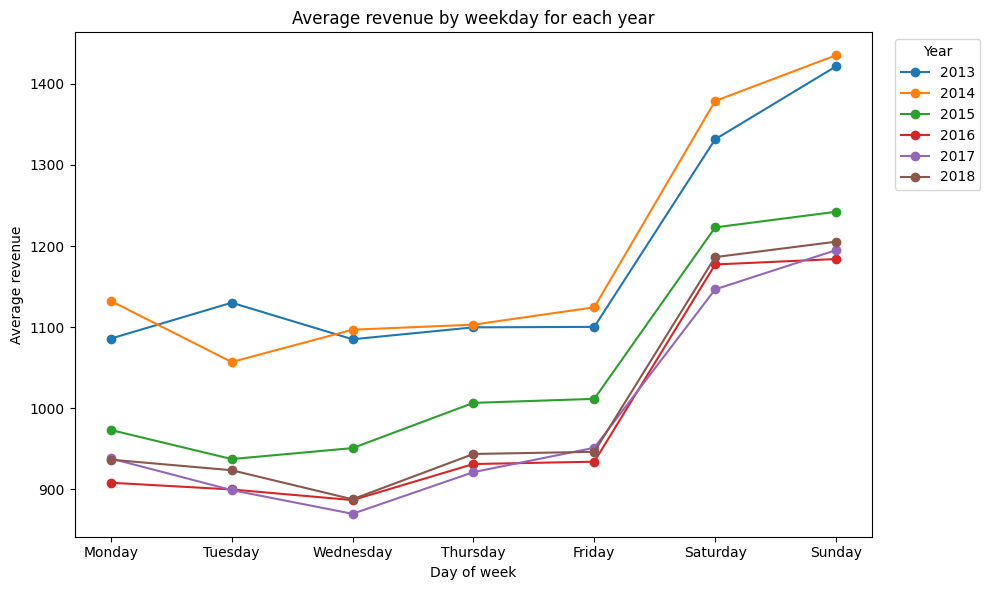

In [230]:
#creating a graph that shows the average revenue per day over time

# compute and plot average revenue by weekday for each year
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')

# extract year and weekday name
merged['Year'] = merged['Date'].dt.year
merged['Weekday'] = merged['Date'].dt.day_name()

# ensure weekday order Mon..Sun
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# pivot: rows = Year, columns = Weekday
pivot = merged.groupby(['Year', 'Weekday'])['Revenue'].mean().unstack(level=1)
pivot = pivot.reindex(columns=weekday_order)  # order columns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
for year in pivot.index:
    ax.plot(weekday_order, pivot.loc[year, weekday_order], marker='o', label=str(year))

ax.set_xlabel('Day of week')
ax.set_ylabel('Average revenue')
ax.set_title('Average revenue by weekday for each year')
ax.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_5474/1699122768.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(weekday_order, rotation=45)
/tmp/ipykernel_5474/1699122768.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(weekday_order, rotation=45)


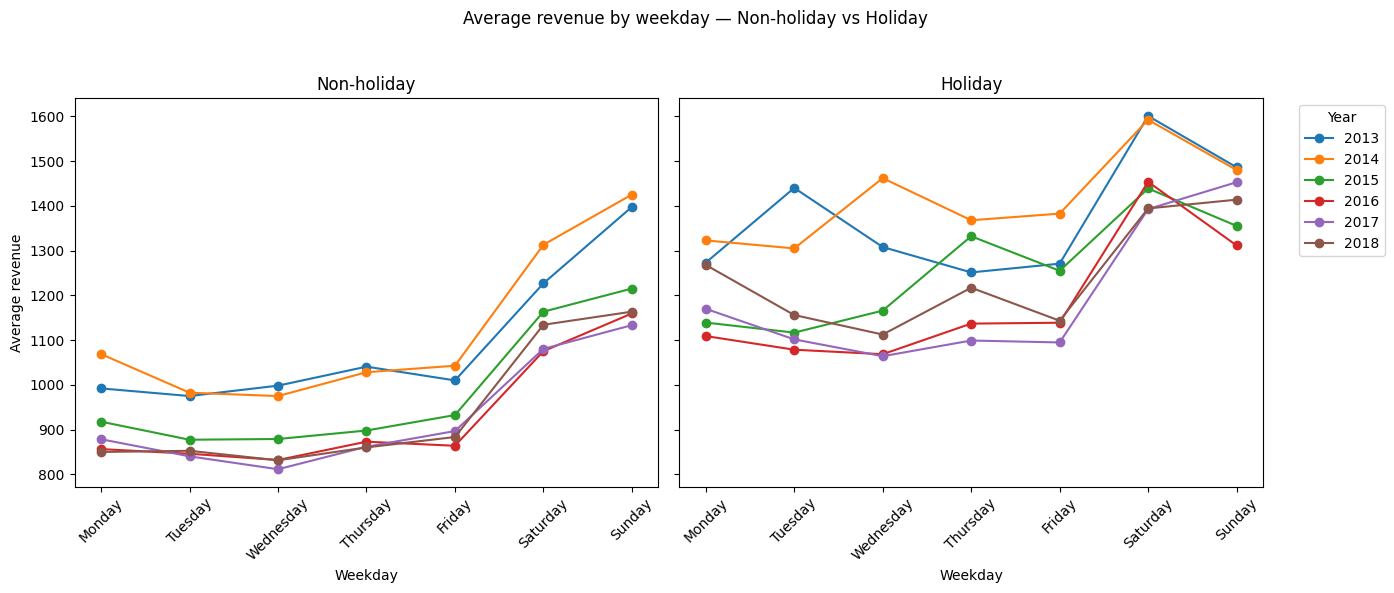

In [231]:
#creating a graph showing the relationship between revenue and school holidays

# plot average revenue by weekday split by holiday flag
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')

# ensure holiday column exists (handles 'holiday' or 'Holiday')
merged['HolidayFlag'] = merged.get('Holiday', merged.get('holiday'))

# extract year and weekday
merged['Year'] = merged['Date'].dt.year
merged['Weekday'] = merged['Date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# group average revenue by Year, Weekday, HolidayFlag
grouped = merged.groupby(['Year', 'Weekday', 'HolidayFlag'])['Revenue'].mean().reset_index()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for ax, flag, title in zip(axes, [0,1], ['Non-holiday', 'Holiday']):
    df_flag = grouped[grouped['HolidayFlag']==flag]
    if df_flag.empty:
        ax.text(0.5, 0.5, f'No data for {title}', ha='center')
        ax.set_title(title)
        continue
    pivot = df_flag.pivot(index='Year', columns='Weekday', values='Revenue').reindex(columns=weekday_order)
    for year in pivot.index:
        ax.plot(weekday_order, pivot.loc[year, weekday_order], marker='o', label=str(year))
    ax.set_title(title)
    ax.set_xlabel('Weekday')
    ax.set_xticklabels(weekday_order, rotation=45)
axes[0].set_ylabel('Average revenue')
axes[1].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Average revenue by weekday — Non-holiday vs Holiday')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [232]:
# creating parameters like "low" "medium" "high" for temperature 

#FIRST OF ALL: CHECKING THE MIN AND MAX FOR EVERY MONTH

# ensure date and temperature columns exist and have correct types
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Temperature'] = pd.to_numeric(merged.get('Temperature', merged.get('Temperatur')), errors='coerce')

# 1) Lowest and highest temperature for each month of the year (Jan..Dec) aggregated across all years
merged['MonthName'] = merged['Date'].dt.month_name()
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
monthly_min_max = merged.groupby('MonthName')['Temperature'].agg(min='min', max='max').reindex(month_order)
print("Min / Max temperature by month (all years):")
print(monthly_min_max)

# 2) If you want month-by-month per year (year-month)
yr_month = merged.groupby(merged['Date'].dt.to_period('M'))['Temperature'].agg(min='min', max='max').reset_index()
yr_month['YearMonth'] = yr_month['Date'].dt.to_timestamp()
yr_month = yr_month[['YearMonth','min','max']]
print("\nMin / Max temperature by year-month:")
print(yr_month.head(24))  # show first 24 rows

Min / Max temperature by month (all years):
               min      max
MonthName                  
January    -8.4750  11.6000
February   -6.1375  11.5000
March      -4.9625  19.7500
April       2.5000  24.3750
May         8.2500  26.8625
June       11.5625  27.8750
July       14.0000  31.2875
August     13.8750  31.4375
September  11.5750  27.8750
October     7.3750  20.0000
November    0.0000  16.5000
December   -3.0000  12.5000

Min / Max temperature by year-month:
    YearMonth      min      max
0  2013-07-01  17.3125  27.2625
1  2013-08-01  16.3875  31.4375
2  2013-09-01  11.5750  24.7000
3  2013-10-01   9.0750  17.6750
4  2013-11-01   2.3125  10.7000
5  2013-12-01   1.0000  11.4375
6  2014-01-01  -8.4750  10.4375
7  2014-02-01   3.2250  11.5000
8  2014-03-01   4.6875  16.4000
9  2014-04-01   5.7625  18.0875
10 2014-05-01  10.2000  26.8625
11 2014-06-01  13.8250  25.7875
12 2014-07-01  15.6875  28.0625
13 2014-08-01  14.0875  26.7250
14 2014-09-01  13.0000  24.0000
15 2014-10-01 

In [233]:
# SECOND: AGGREGATING MONTHS BY SEASON

# ensure Date column exists
merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))

# map months to seasons
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}
merged['MonthNum'] = merged['Date'].dt.month
merged['Season'] = merged['MonthNum'].map(month_to_season)

# example aggregations
season_temp_min_max = merged.groupby('Season')['Temperature'].agg(min='min', max='max').reindex(['Winter','Spring','Summer','Autumn'])
print("Temperature min/max by season:")
print(season_temp_min_max)

# average revenue by season per year (optional)
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['Year'] = merged['Date'].dt.year
seasonal_revenue = merged.groupby(['Year','Season'])['Revenue'].mean().unstack('Season').reindex(columns=['Winter','Spring','Summer','Autumn'])
print("\nAverage revenue by season per year:")
print(seasonal_revenue)

Temperature min/max by season:
            min      max
Season                  
Winter  -8.4750  12.5000
Spring  -4.9625  26.8625
Summer  11.5625  31.4375
Autumn   0.0000  27.8750

Average revenue by season per year:
Season       Winter       Spring       Summer       Autumn
Year                                                      
2013     983.298449          NaN  1486.549703  1028.639297
2014    1004.533811  1120.653967  1433.776130  1185.053641
2015     986.664404   981.767347  1246.045513   976.300207
2016     886.038145   926.090349  1213.837414   931.668236
2017     849.763844   934.849261  1214.218956   953.745743
2018     812.668964   941.228530  1280.439698          NaN


In [234]:
#THIRD: CREATING "LOW"; "MEDIUM"; "HIGH" CATEGORIES FOR TEMP

merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Temperature'] = pd.to_numeric(merged.get('Temperature', merged.get('Temperatur')), errors='coerce')

if 'Season' not in merged.columns:
    month_to_season = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }
    merged['MonthNum'] = merged['Date'].dt.month
    merged['Season'] = merged['MonthNum'].map(month_to_season)

# compute per-season min/max
season_bounds = merged.groupby('Season')['Temperature'].agg(min_temp='min', max_temp='max')
print("Season bounds (min/max):")
print(season_bounds)

# classify temperature relative to season-specific bounds (use thirds)
def classify_temp(row):
    t = row['Temperature']
    s = row['Season']
    if pd.isna(t) or pd.isna(s):
        return pd.NA
    mn = season_bounds.loc[s, 'min_temp']
    mx = season_bounds.loc[s, 'max_temp']
    if pd.isna(mn) or pd.isna(mx):
        return pd.NA
    if mn == mx:
        return 'medium'
    span = mx - mn
    low_thr = mn + span / 3
    high_thr = mn + 2 * span / 3
    if t <= low_thr:
        return 'low'
    if t <= high_thr:
        return 'medium'
    return 'high'

merged['TempLevel'] = merged.apply(classify_temp, axis=1)

# quick check
print(merged['TempLevel'].value_counts(dropna=False))

Season bounds (min/max):
        min_temp  max_temp
Season                    
Autumn    0.0000   27.8750
Spring   -4.9625   26.8625
Summer   11.5625   31.4375
Winter   -8.4750   12.5000
TempLevel
medium    1127
low        355
high       334
<NA>         3
Name: count, dtype: int64


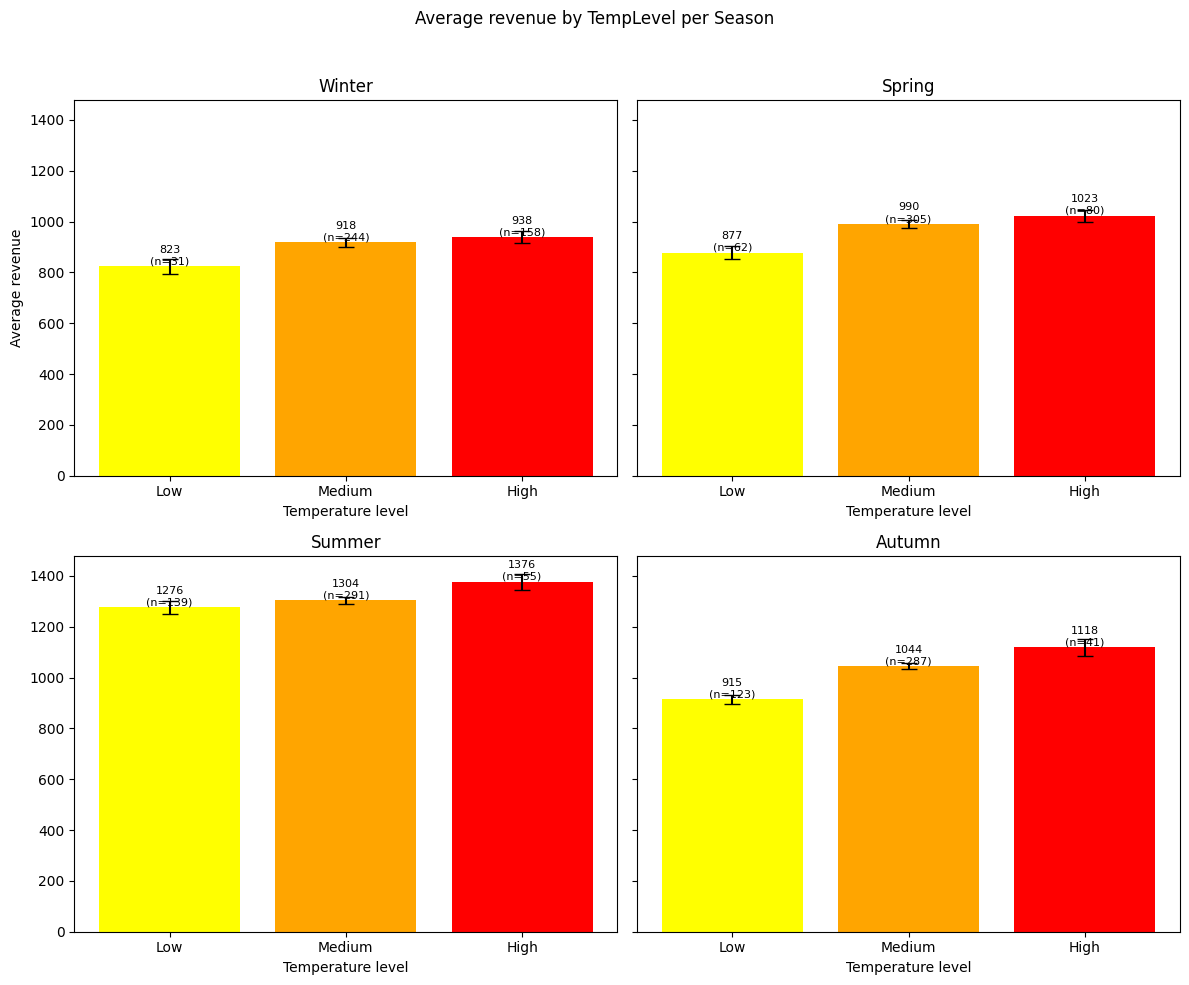

In [235]:
#FOURTH: CREATING GRAPHS TO VISUALIZE THE DATA

import numpy as np
import matplotlib.pyplot as plt

# ensure necessary columns
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['Season'] = merged['Season']  # assume Season exists
merged['TempLevel'] = merged['TempLevel']  # assume TempLevel exists

temp_order = ['low', 'medium', 'high']
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for i, season in enumerate(seasons):
    ax = axes.flat[i]
    df = merged[merged['Season'] == season]
    ax.set_title(season)
    if df.empty:
        ax.text(0.5, 0.5, 'No data', ha='center')
        continue

    stats = df.groupby('TempLevel')['Revenue'].agg(['mean', 'count', 'std']).reindex(temp_order)
    means = stats['mean'].fillna(0).values
    counts = stats['count'].fillna(0).astype(int).values
    sem = (stats['std'] / np.sqrt(stats['count'])).fillna(0).values

    x = np.arange(len(temp_order))
    ax.bar(x, means, yerr=sem, capsize=6, color=['yellow', 'orange', 'red'])
    ax.set_xticks(x)
    ax.set_xticklabels([t.capitalize() for t in temp_order])
    ax.set_xlabel('Temperature level')
    for xi, m, c in zip(x, means, counts):
        ax.text(xi, m, f'{m:.0f}\n(n={c})', ha='center', va='bottom', fontsize=8)
    
axes[0,0].set_ylabel('Average revenue')
plt.suptitle('Average revenue by TempLevel per Season')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



/tmp/ipykernel_5474/2120188153.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)


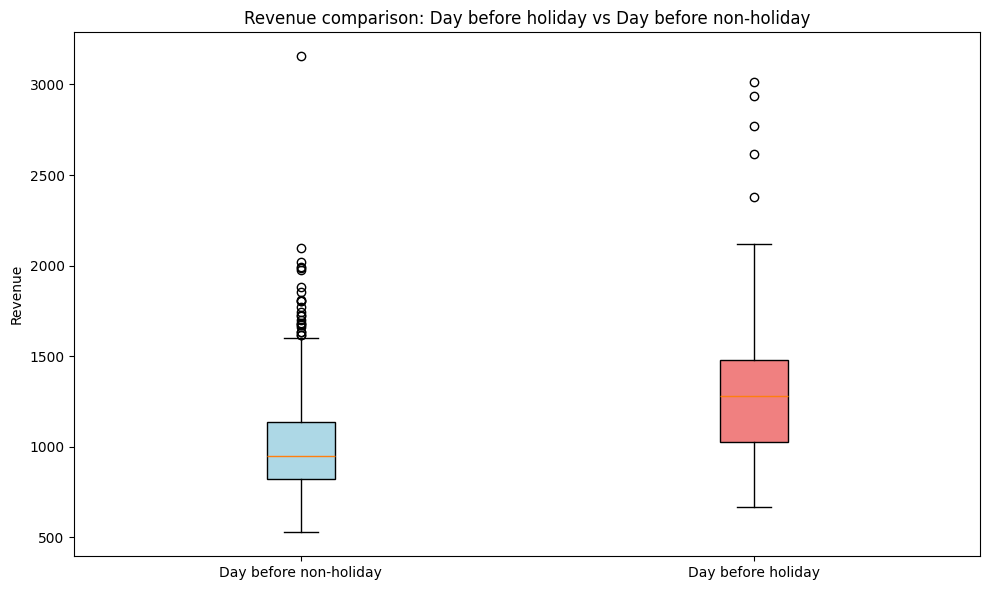

Day before non-holiday: mean=995.98, std=244.75
Day before holiday: mean=1272.47, std=324.85


In [236]:
# visualize differences in revenue: day before holiday vs day before non-holiday

merged['Date'] = pd.to_datetime(merged.get('Date', merged.get('Datum')))
merged['Revenue'] = pd.to_numeric(merged.get('Revenue', merged.get('Umsatz')), errors='coerce')
merged['HolidayFlag'] = merged.get('Holiday', merged.get('holiday'))

# shift holiday flag forward by 1 day to identify "day before holiday"
merged['NextDayHoliday'] = merged['HolidayFlag'].shift(-1)

# filter: day before a holiday vs day before a non-holiday
day_before_holiday = merged[merged['NextDayHoliday'] == 1]['Revenue']
day_before_non_holiday = merged[merged['NextDayHoliday'] == 0]['Revenue']

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [day_before_non_holiday.dropna(), day_before_holiday.dropna()]
labels = ['Day before non-holiday', 'Day before holiday']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

# color boxes
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)

ax.set_ylabel('Revenue')
ax.set_title('Revenue comparison: Day before holiday vs Day before non-holiday')
plt.tight_layout()
plt.show()

# print statistics
print(f"Day before non-holiday: mean={day_before_non_holiday.mean():.2f}, std={day_before_non_holiday.std():.2f}")
print(f"Day before holiday: mean={day_before_holiday.mean():.2f}, std={day_before_holiday.std():.2f}")

In [237]:
# Deleting useless columns to free up memory
del merged["MonthName"]
del merged["MonthNum"]
del merged["YearMonth"]
del merged["HolidayFlag"]

In [238]:
# Setting date as index 
merged.set_index("Date", inplace=True)
merged.head()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,0,1,0,2013,Monday,Summer,low,1.0
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,0,1,0,2013,Tuesday,Summer,low,1.0
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,0,1,0,2013,Wednesday,Summer,medium,1.0
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,0,1,0,2013,Thursday,Summer,medium,1.0
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,0,1,0,2013,Friday,Summer,medium,1.0


In [239]:
# Visualizing the last 5 rows of the merged dataframe
merged.tail()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2018-07-27,1572.847053,0.0,27.5875,16.0,5.0,0,1,0,2018,Friday,Summer,high,1.0
2018-07-28,1646.938417,3.0,28.7500,11.0,95.0,0,1,0,2018,Saturday,Summer,high,1.0
2018-07-29,1750.221545,0.0,24.5500,6.0,NaN,0,1,0,2018,Sunday,Summer,medium,1.0
2018-07-30,1510.458573,6.0,27.7875,10.0,21.0,0,1,0,2018,Monday,Summer,high,1.0
2018-07-31,1313.474071,5.0,31.2875,11.0,NaN,0,1,0,2018,Tuesday,Summer,high,NaN


In [240]:
# Reading test.csv and setting date as index
test = pd.read_csv("/workspaces/TeamCPH/data/test.csv", parse_dates=["Datum"])
test.rename(columns={"Datum": "Date"}, inplace=True)
test.set_index("Date", inplace=True)
del test["id"]
test.head()


,Warengruppe
Date,
2018-08-01,1
2018-08-02,1
2018-08-03,1
2018-08-04,1
2018-08-05,1


In [241]:
merged.head()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,0,1,0,2013,Monday,Summer,low,1.0
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,0,1,0,2013,Tuesday,Summer,low,1.0
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,0,1,0,2013,Wednesday,Summer,medium,1.0
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,0,1,0,2013,Thursday,Summer,medium,1.0
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,0,1,0,2013,Friday,Summer,medium,1.0


In [242]:
# Merging test.csv to merged dataframe, excluding 'Warengruppe' column
# Fill missing values in test.csv with 0

# Drop 'Warengruppe' from test if it exists
if 'Warengruppe' in test.columns:
    test = test.drop(columns=['Warengruppe'])

# Drop 'Warengruppe' from merged if it exists
if 'Warengruppe' in merged.columns:
    merged = merged.drop(columns=['Warengruppe'])

# Concatenate the dataframes
merged = pd.concat([merged, test.fillna(0)])

# Remove duplicate dates, keeping the first occurrence
merged = merged[~merged.index.duplicated(keep='first')]

# Sort by date
merged = merged.sort_index()

merged.tail()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2019-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
merged.head()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,0.0,1.0,0.0,2013.0,Monday,Summer,low,1.0
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,0.0,1.0,0.0,2013.0,Tuesday,Summer,low,1.0
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,0.0,1.0,0.0,2013.0,Wednesday,Summer,medium,1.0
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,0.0,1.0,0.0,2013.0,Thursday,Summer,medium,1.0
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,0.0,1.0,0.0,2013.0,Friday,Summer,medium,1.0


In [244]:
# Following videos from week 4 

# VIDEO 1

#Checking data types of the merged dataframe
merged.dtypes

Revenue           float64
CloudCover        float64
Temperature       float64
WindSpeed         float64
WeatherCode       float64
KielerWeek        float64
Holiday           float64
Easter            float64
Year              float64
Weekday            object
Season             object
TempLevel          object
NextDayHoliday    float64
dtype: object

In [245]:
# I see that all data types are either floats or objects. 

# I convert weekday to categorical data type 
merged["Weekday"] = pd.Categorical(
    merged["Weekday"],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)

#I convert season into categorical data type
season_categories = ['Winter', 'Spring', 'Summer', 'Autumn']
merged['Season'] = pd.Categorical(merged['Season'], categories=season_categories, ordered=True)
merged['Season'].head()



Date
2013-07-01    Summer
2013-07-02    Summer
2013-07-03    Summer
2013-07-04    Summer
2013-07-05    Summer
Name: Season, dtype: category
Categories (4, object): ['Winter' < 'Spring' < 'Summer' < 'Autumn']

In [246]:
# Converting tempLevel into categorical data type with order low < medium < high

temp_order = ["low", "medium", "high"]
merged["TempLevel"] = pd.Categorical(merged["TempLevel"],
                                  categories=temp_order,
                                  ordered=True)

merged["TempLevel"].dtype  
merged["TempLevel"].head

<bound method NDFrame.head of Date
2013-07-01       low
2013-07-02       low
2013-07-03    medium
2013-07-04    medium
2013-07-05    medium
               ...  
2019-07-26       NaN
2019-07-27       NaN
2019-07-28       NaN
2019-07-29       NaN
2019-07-30       NaN
Name: TempLevel, Length: 2174, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']>

In [247]:
# Converting binary columns into boolean data type
binary_columns = ['KielerWeek', 'Holiday', 'NextDayHoliday']
for col in binary_columns:
    if col in merged.columns:
        merged[col] = merged[col].astype(bool)  

merged.dtypes


Revenue            float64
CloudCover         float64
Temperature        float64
WindSpeed          float64
WeatherCode        float64
KielerWeek            bool
Holiday               bool
Easter             float64
Year               float64
Weekday           category
Season            category
TempLevel         category
NextDayHoliday        bool
dtype: object

In [248]:
# Converting WeatherCode to categorical data type
merged["WeatherCode"] = merged["WeatherCode"].astype("category")

# Converting year to int16 data type
df["Year"] = df["Year"].astype("int16")

# Checking changes
merged.dtypes

Revenue            float64
CloudCover         float64
Temperature        float64
WindSpeed          float64
WeatherCode       category
KielerWeek            bool
Holiday               bool
Easter             float64
Year               float64
Weekday           category
Season            category
TempLevel         category
NextDayHoliday        bool
dtype: object

In [249]:
# Checking index data type (should be datetime)
merged.index.dtype


dtype('<M8[ns]')

In [250]:
# VIDEO 2

# Now that all data types are optimized, I can access specifc dates and get information about them

#Example

merged.loc['2016-06-01']
merged.loc['2016-06-01':'2016-06-07']

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday
Date,,,,,,,,,,,,,
2016-06-01,819.616365,4.0,21.750,16.0,0.0,False,False,0.0,2016.0,Wednesday,Summer,medium,False
2016-06-02,736.036903,1.0,21.500,13.0,NaN,False,False,0.0,2016.0,Thursday,Summer,medium,False
2016-06-03,895.674468,0.0,21.875,10.0,NaN,False,False,0.0,2016.0,Friday,Summer,medium,False
2016-06-04,1129.292453,0.0,24.500,7.0,NaN,False,False,0.0,2016.0,Saturday,Summer,medium,False
2016-06-05,1067.389591,0.0,25.250,9.0,NaN,False,False,0.0,2016.0,Sunday,Summer,high,False
2016-06-06,850.647751,1.0,22.875,15.0,NaN,False,False,0.0,2016.0,Monday,Summer,medium,False
2016-06-07,828.708353,1.0,25.375,8.0,NaN,False,False,0.0,2016.0,Tuesday,Summer,high,False


In [251]:
# Before moving onto VIDEO 3, I want to make some changes to the dataset merged

# Currently revenue is a compound variable, made of of the revenues from different product categories. I want to create a reveneuecolumn for each product category

# I go back to the umstazdaten_gekuerzt.csv file and read it again
df = pd.read_csv("/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv")

# make sure date is datetime
df["Datum"] = pd.to_datetime(df["Datum"])

# pivot to wide format
wide = df.pivot_table(
    index="Datum",          # one row per day
    columns="Warengruppe",  # product types become columns
    values="Umsatz",        # fill with revenue
    aggfunc="sum"           # in case there are duplicates per day/type
)

# rename columns nicely
wide = wide.rename(columns={
    1: "Revenue prod 1",
    2: "Revenue prod 2",
    3: "Revenue prod 3",
    4: "Revenue prod 4",
    5: "Revenue prod 5",
    6: "Revenue prod 6",
})

# optional: if some days are missing a product type, fill with 0
wide = wide.fillna(0)
print(wide.head())


Warengruppe  Revenue prod 1  Revenue prod 2  Revenue prod 3  Revenue prod 4  \
Datum                                                                         
2013-07-01       148.828353      535.856285      201.198426       65.890169   
2013-07-02       159.793757      546.780787      265.261254       74.543917   
2013-07-03       111.885594      427.343259      210.260241       69.262728   
2013-07-04       168.864941      454.859641      190.686641       61.490175   
2013-07-05       171.280754      492.818804      181.644870       86.759861   

Warengruppe  Revenue prod 5  Revenue prod 6  
Datum                                        
2013-07-01       317.475875             0.0  
2013-07-02       383.628682             0.0  
2013-07-03       305.523072             0.0  
2013-07-04       308.408168             0.0  
2013-07-05       355.518770             0.0  


In [252]:
# Now I want to merge these new revenue columns into the merged dataframe
merged = merged.merge(wide, left_index=True, right_index=True, how="left")
merged.head()

,Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,Summer,low,True,148.828353,535.856285,201.198426,65.890169,317.475875,0.0
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,Summer,low,True,159.793757,546.780787,265.261254,74.543917,383.628682,0.0
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,Summer,medium,True,111.885594,427.343259,210.260241,69.262728,305.523072,0.0
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,Summer,medium,True,168.864941,454.859641,190.686641,61.490175,308.408168,0.0
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,Summer,medium,True,171.280754,492.818804,181.644870,86.759861,355.518770,0.0


In [253]:
# I want the rename the revenue column as total revenue
merged = merged.rename(columns={"Revenue": "Total Revenue"})
merged.head()

,Total Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,Summer,low,True,148.828353,535.856285,201.198426,65.890169,317.475875,0.0
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,Summer,low,True,159.793757,546.780787,265.261254,74.543917,383.628682,0.0
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,Summer,medium,True,111.885594,427.343259,210.260241,69.262728,305.523072,0.0
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,Summer,medium,True,168.864941,454.859641,190.686641,61.490175,308.408168,0.0
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,Summer,medium,True,171.280754,492.818804,181.644870,86.759861,355.518770,0.0


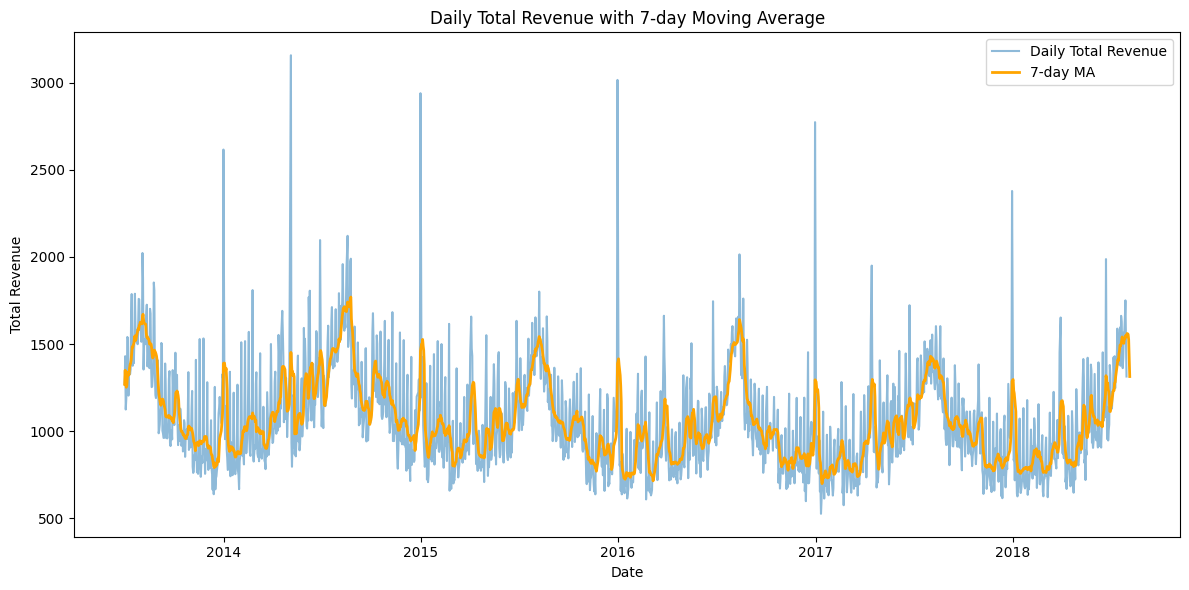

In [254]:
# VIDEO 3

# calculate moving average of total revenue with window size 7 days (one week)
merged['Total Revenue MA7'] = merged['Total Revenue'].rolling(window=7, min_periods=1).mean()
merged[['Total Revenue', 'Total Revenue MA7']].head()

# Plotting moving average into a line chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(merged.index, merged['Total Revenue'], label='Daily Total Revenue', alpha=0.5)
ax.plot(merged.index, merged[
    'Total Revenue MA7'], label='7-day MA', color='orange', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Revenue')
ax.set_title('Daily Total Revenue with 7-day Moving Average')
ax.legend()
plt.tight_layout()
plt.show()


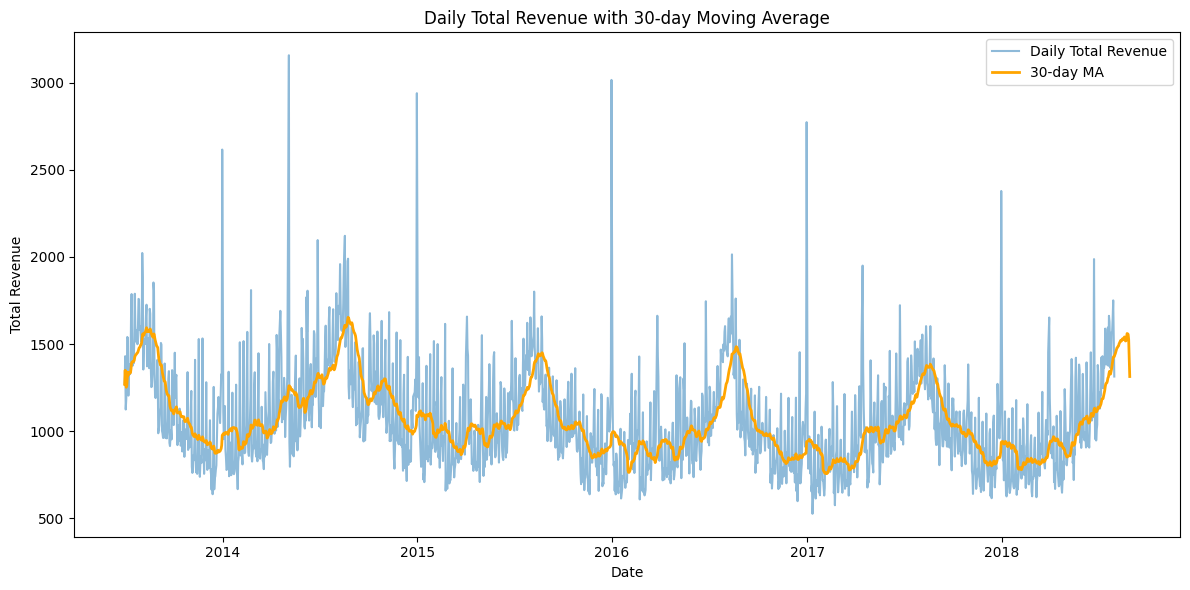

In [255]:
# calculate moving average of total revenue with window size 30 days (one month)
merged['Total Revenue MA30'] = merged['Total Revenue'].rolling(window=30, min_periods=1).mean()
merged[['Total Revenue', 'Total Revenue MA30']].head()

# Plotting moving average into a line chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(merged.index, merged['Total Revenue'], label='Daily Total Revenue', alpha=0.5)
ax.plot(merged.index, merged['Total Revenue MA30'], label='30-day MA', color='orange', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Total Revenue')
ax.set_title('Daily Total Revenue with 30-day Moving Average')
ax.legend()
plt.tight_layout()
plt.show()

In [256]:
# checking what the spikes in the graphs are

spikes = merged.sort_values("Total Revenue", ascending=False).head(20)
print(spikes[["Total Revenue"]])

            Total Revenue
Date                     
2014-05-05    3156.413344
2015-12-31    3014.915888
2014-12-31    2938.717609
2016-12-31    2772.611848
2013-12-31    2615.411466
2017-12-31    2377.797450
2014-08-18    2120.587134
2014-06-28    2096.209536
2013-08-03    2022.092978
2016-08-13    2014.038470
2014-08-24    1989.261909
2018-06-23    1987.066569
2014-08-23    1974.930059
2014-08-09    1958.276501
2017-04-15    1949.711999
2014-08-16    1933.960953
2013-08-04    1879.178864
2013-08-24    1852.823513
2014-02-23    1809.345515
2013-08-25    1806.358547


In [257]:
# Checking if the spikes are correlated with holidays or Kieler week
top_dates = spikes.index
print(merged.loc[top_dates, ["Holiday", "KielerWeek", "Total Revenue"]])

            Holiday  KielerWeek  Total Revenue
Date                                          
2014-05-05    False       False    3156.413344
2015-12-31     True       False    3014.915888
2014-12-31     True       False    2938.717609
2016-12-31     True       False    2772.611848
2013-12-31     True       False    2615.411466
2017-12-31     True       False    2377.797450
2014-08-18     True       False    2120.587134
2014-06-28    False        True    2096.209536
2013-08-03     True       False    2022.092978
2016-08-13     True       False    2014.038470
2014-08-24    False       False    1989.261909
2018-06-23    False        True    1987.066569
2014-08-23     True       False    1974.930059
2014-08-09     True       False    1958.276501
2017-04-15     True       False    1949.711999
2014-08-16     True       False    1933.960953
2013-08-04    False       False    1879.178864
2013-08-24    False       False    1852.823513
2014-02-23    False       False    1809.345515
2013-08-25   

In [258]:
# looking at whetehr the spikes are correlated with summer 
merged["IsSummer"] = merged["Season"] == "Summer"

top_dates = spikes.index
print(merged.loc[top_dates, ["IsSummer", "Season", "Total Revenue"]])


            IsSummer  Season  Total Revenue
Date                                       
2014-05-05     False  Spring    3156.413344
2015-12-31     False  Winter    3014.915888
2014-12-31     False  Winter    2938.717609
2016-12-31     False  Winter    2772.611848
2013-12-31     False  Winter    2615.411466
2017-12-31     False  Winter    2377.797450
2014-08-18      True  Summer    2120.587134
2014-06-28      True  Summer    2096.209536
2013-08-03      True  Summer    2022.092978
2016-08-13      True  Summer    2014.038470
2014-08-24      True  Summer    1989.261909
2018-06-23      True  Summer    1987.066569
2014-08-23      True  Summer    1974.930059
2014-08-09      True  Summer    1958.276501
2017-04-15     False  Spring    1949.711999
2014-08-16      True  Summer    1933.960953
2013-08-04      True  Summer    1879.178864
2013-08-24      True  Summer    1852.823513
2014-02-23     False  Winter    1809.345515
2013-08-25      True  Summer    1806.358547


In [259]:
# VIDEO 4: Percentage changes

Total_rev_percent_change = merged['Total Revenue'].pct_change() 
Total_rev_percent_change.head()
Total_rev_percent_change * 100


/tmp/ipykernel_5474/4066642736.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  Total_rev_percent_change = merged['Total Revenue'].pct_change()


Date
2013-07-01          NaN
2013-07-02    12.665700
2013-07-03   -21.379840
2013-07-04     5.339857
2013-07-05     8.757296
                ...    
2019-07-26     0.000000
2019-07-27     0.000000
2019-07-28     0.000000
2019-07-29     0.000000
2019-07-30     0.000000
Name: Total Revenue, Length: 2174, dtype: float64

In [260]:
# Linear regression model

merged.head()

# My dependent variable is Total Revenue

# I need to find my independent variables 

# I create a list of numeric columns of interest 
numeric_cols = [
    'CloudCover', 
    'Temperature', 
    'WindSpeed', 
    'KielerWeek', 
    'Holiday',
    'Total Revenue', 
    'Revenue prod 1', 
    'Revenue prod 2', 
    'Revenue prod 3', 
    'Revenue prod 4', 
    'Revenue prod 5', 
    'Revenue prod 6'
]


In [261]:
merged.head()

,Total Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,...,NextDayHoliday,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6,Total Revenue MA7,Total Revenue MA30,IsSummer
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,...,True,148.828353,535.856285,201.198426,65.890169,317.475875,0.0,1269.249107,1269.249107,True
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,...,True,159.793757,546.780787,265.261254,74.543917,383.628682,0.0,1349.628752,1349.628752,True
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,...,True,111.885594,427.343259,210.260241,69.262728,305.523072,0.0,1274.510800,1274.510800,True
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,...,True,168.864941,454.859641,190.686641,61.490175,308.408168,0.0,1251.960491,1251.960491,True
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,...,True,171.280754,492.818804,181.644870,86.759861,355.518770,0.0,1259.173005,1259.173005,True


In [262]:
# putting # in front of everything because everytime i run all, this takes a lot of time and i don't need it

# i create a pair plot to visualize relationships between numeric variables
#import matplotlib.pyplot as plt
#import seaborn as sns
#sns.pairplot(merged[numeric_cols])
#plt.suptitle('Pair plot of numeric variables', y=1.02)
#plt.show()


In [263]:
# I cannot see anything in the graph above, so i drop revenue prod 1 to 6 and Kieler Week and create a new list (numeric_cols_1)

# numeric_cols_1 = [
#    'CloudCover', 
#    'Temperature', 
#    'WindSpeed', 
#    'Holiday',
#    'Total Revenue', 
#]

#sns.pairplot(merged[numeric_cols_1])
#plt.suptitle('Pair plot of numeric variables', y=1.02)
# plt.show()

In [264]:
# Correlation table
merged[numeric_cols].corr()

,CloudCover,Temperature,WindSpeed,KielerWeek,Holiday,Total Revenue,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6
CloudCover,1.000000,-0.392340,0.043537,0.013429,-0.083059,-0.184699,-0.074923,-0.210864,-0.236922,-0.002109,-0.071428,0.143045
Temperature,-0.392340,1.000000,-0.002094,0.136812,0.248676,0.477257,0.228403,0.566486,0.622965,-0.119104,0.165250,-0.317609
WindSpeed,0.043537,-0.002094,1.000000,0.019865,0.020262,0.018205,0.037308,0.028470,0.002853,-0.005003,0.014825,-0.061159
KielerWeek,0.013429,0.136812,0.019865,1.000000,0.522221,0.126402,0.054958,0.155228,0.126438,-0.033030,0.062338,-0.061612
Holiday,-0.083059,0.248676,0.020262,0.522221,1.000000,0.401991,0.273259,0.414212,0.443407,-0.064456,0.200891,-0.116428
Total Revenue,-0.184699,0.477257,0.018205,0.126402,0.401991,1.000000,0.400228,0.931718,0.876289,0.243665,0.735720,-0.166040
Revenue prod 1,-0.074923,0.228403,0.037308,0.054958,0.273259,0.400228,1.000000,0.248630,0.325178,-0.273261,0.300934,-0.108999
Revenue prod 2,-0.210864,0.566486,0.028470,0.155228,0.414212,0.931718,0.248630,1.000000,0.904985,0.210643,0.507946,-0.220393
Revenue prod 3,-0.236922,0.622965,0.002853,0.126438,0.443407,0.876289,0.325178,0.904985,1.000000,0.089617,0.430600,-0.249731
Revenue prod 4,-0.002109,-0.119104,-0.005003,-0.033030,-0.064456,0.243665,-0.273261,0.210643,0.089617,1.000000,0.099613,-0.078314


In [265]:
# merged[numeric_cols_1].corr()

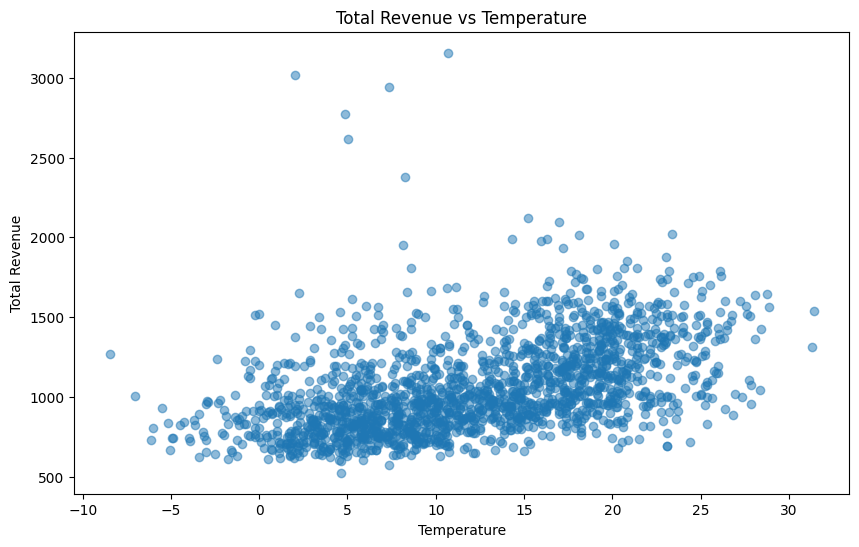

In [266]:
# creating my first linear regression model
plt.figure(figsize=(10,6))
plt.scatter(merged['Temperature'], merged['Total Revenue'], alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Total Revenue')
plt.title('Total Revenue vs Temperature')
plt.show()

In [267]:
# Importing statsmodels for linear regression

import statsmodels.api as sm #to make this work type in terminal: pip install statsmodels

# Setting up variables 
Y = merged['Total Revenue']  
X = sm.add_constant(merged['Temperature'])

X

,const,Temperature
Date,,
2013-07-01,1.0,17.8375
2013-07-02,1.0,17.3125
2013-07-03,1.0,21.0750
2013-07-04,1.0,18.8500
2013-07-05,1.0,19.9750
...,...,...
2019-07-26,1.0,NaN
2019-07-27,1.0,NaN
2019-07-28,1.0,NaN


In [268]:
Y

Date
2013-07-01    1269.249107
2013-07-02    1430.008397
2013-07-03    1124.274894
2013-07-04    1184.309567
2013-07-05    1288.023060
                 ...     
2019-07-26            NaN
2019-07-27            NaN
2019-07-28            NaN
2019-07-29            NaN
2019-07-30            NaN
Name: Total Revenue, Length: 2174, dtype: float64

In [269]:
# regression model 
#this doesn't work because of the nan values: model = sm.OLS(Y, X)
#results = model.fit() 

# It gives me an error because there are NaN values. I want to create a copy of the merged dataset without NaN values
merged_clean = merged.dropna(subset=['Total Revenue', 'Temperature'])
Y = merged_clean['Total Revenue']  
X = sm.add_constant(merged_clean['Temperature'])

X

,const,Temperature
Date,,
2013-07-01,1.0,17.8375
2013-07-02,1.0,17.3125
2013-07-03,1.0,21.0750
2013-07-04,1.0,18.8500
2013-07-05,1.0,19.9750
...,...,...
2018-07-27,1.0,27.5875
2018-07-28,1.0,28.7500
2018-07-29,1.0,24.5500


In [270]:
Y

Date
2013-07-01    1269.249107
2013-07-02    1430.008397
2013-07-03    1124.274894
2013-07-04    1184.309567
2013-07-05    1288.023060
                 ...     
2018-07-27    1572.847053
2018-07-28    1646.938417
2018-07-29    1750.221545
2018-07-30    1510.458573
2018-07-31    1313.474071
Name: Total Revenue, Length: 1816, dtype: float64

In [271]:
# now that i can see there are no nan values, i can create the model
model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     535.1
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          5.98e-104
Time:                        11:43:45   Log-Likelihood:                -12641.
No. Observations:                1816   AIC:                         2.529e+04
Df Residuals:                    1814   BIC:                         2.530e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         827.9579     11.722     70.633      

In [272]:
# The R sqaured is very low (0.228), meaning that temperature explains only 22.8% of the variance in total revenue. This suggests that temperature alone is not a strong predictor of total revenue in this dataset.
# The p-value shows statistical significance (p < 0.05), indicating that there is a statistically significant relationship between temperature and total revenue.

In [273]:
# creating equation of line of best fit
results.params

const          827.957906
Temperature     19.090871
dtype: float64

In [274]:
type(results.params)

pandas.core.series.Series

In [275]:
m = results.params['Temperature']
b = results.params['const']

In [276]:
# Example: predicting total revenue for a temperature of 20 degrees
Temperature = 20
Total_Revenue_Predicted = m * Temperature + b
Total_Revenue_Predicted


np.float64(1209.775334271474)

In [277]:
# VScode crashed so I am redoing the multilinear regression model with multiple variables and then dummy varibales for categorical variables

# first i want to see the head of my data set to remember the variables
merged_clean.head()

# dropping IsSummer and total revenue MA7 and total revenue MA30
# merged_clean = merged_clean.drop(columns=['IsSummer', 'Total Revenue MA7', 'Total Revenue MA30'])
merged_clean = merged_clean.drop(columns=['Total Revenue MA7', 'Total Revenue MA30'])
merged_clean.head()

,Total Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,Season,TempLevel,NextDayHoliday,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6,IsSummer
Date,,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,Summer,low,True,148.828353,535.856285,201.198426,65.890169,317.475875,0.0,True
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,Summer,low,True,159.793757,546.780787,265.261254,74.543917,383.628682,0.0,True
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,Summer,medium,True,111.885594,427.343259,210.260241,69.262728,305.523072,0.0,True
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,Summer,medium,True,168.864941,454.859641,190.686641,61.490175,308.408168,0.0,True
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,Summer,medium,True,171.280754,492.818804,181.644870,86.759861,355.518770,0.0,True


In [278]:
# adding more than one predictor variable to the model
predictors = [
    'Temperature', 
    'WindSpeed'
]

Y = merged_clean['Total Revenue']
X = sm.add_constant(merged_clean[predictors])

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# still pretty low R squared.



                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     267.9
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          1.13e-102
Time:                        11:43:45   Log-Likelihood:                -12640.
No. Observations:                1816   AIC:                         2.529e+04
Df Residuals:                    1813   BIC:                         2.530e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         813.0832     19.820     41.023      

In [279]:
# adding categotical variales to the model to increase the R squared

# Adding categorical variables to my list of predictors
predictors = [
    'Temperature',
    'Season',
    'Weekday',
    'TempLevel',
    'Holiday',
    'NextDayHoliday'
]

# i didn't include windspeed because it doesn't increase the accuracy of the model

# Y stays the same
Y = merged_clean['Total Revenue']

# now i need to create X taking into consideration that some of my predictors are categorical varibales
X = sm.add_constant(pd.get_dummies(merged_clean[predictors], columns = ['Weekday', 'Season', 'TempLevel', 'Holiday', 'NextDayHoliday'], drop_first=True))
X.head()


,const,Temperature,Weekday_Tuesday,Weekday_Wednesday,Weekday_Thursday,Weekday_Friday,Weekday_Saturday,Weekday_Sunday,Season_Spring,Season_Summer,Season_Autumn,TempLevel_medium,TempLevel_high,Holiday_True,NextDayHoliday_True
Date,,,,,,,,,,,,,,,
2013-07-01,1.0,17.8375,False,False,False,False,False,False,False,True,False,False,False,True,True
2013-07-02,1.0,17.3125,True,False,False,False,False,False,False,True,False,False,False,True,True
2013-07-03,1.0,21.0750,False,True,False,False,False,False,False,True,False,True,False,True,True
2013-07-04,1.0,18.8500,False,False,True,False,False,False,False,True,False,True,False,True,True
2013-07-05,1.0,19.9750,False,False,False,True,False,False,False,True,False,True,False,True,True


In [280]:
# I need to fix the X before i can perfom the OLS since the OLS only accepts numeric data types. I do that by using dtype=float in get dummies
X = sm.add_constant(pd.get_dummies(merged_clean[predictors], columns = ['Weekday', 'Season', 'TempLevel', 'Holiday', 'NextDayHoliday'], drop_first=True, dtype=float))

# now i can create the model
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# the R square has increased

                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     158.4
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          2.72e-301
Time:                        11:43:45   Log-Likelihood:                -12147.
No. Observations:                1816   AIC:                         2.432e+04
Df Residuals:                    1801   BIC:                         2.441e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 798.5956    

In [281]:
# I want to create other variables to increase the R squared even more

# i want to create a variable weekday vs weekend
merged_clean['IsWeekend'] = merged_clean['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
merged_clean['IsWeekend'].head()

# I want this to be a boolean variable
merged_clean['IsWeekend'] = merged_clean['IsWeekend'].astype(bool)
merged_clean['IsWeekend'].dtype

dtype('bool')

In [282]:
# I want to create a variable that describes whether today the temperature is higher than yesterday
merged_clean['TempHigherThanYesterday'] = (merged_clean['Temperature'] > merged_clean['Temperature'].shift(1)).astype(int)
merged_clean['TempHigherThanYesterday'].head()

# I want this to be a boolean variable
merged_clean['TempHigherThanYesterday'] = merged_clean['TempHigherThanYesterday'].astype(bool)
merged_clean['TempHigherThanYesterday'].dtype

dtype('bool')

In [283]:
# I insert my new two variables into the list of predictors
predictors = [
    'Season',
    'TempLevel',
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
]

# Y stays the same
Y = merged_clean['Total Revenue']

# now i need to create X taking into consideration that some of my predictors are categorical varibales
X = sm.add_constant(pd.get_dummies(merged_clean[predictors], columns = ['Season', 'TempLevel', 'NextDayHoliday', 'Holiday', 'NextDayHoliday', 'IsWeekend'], drop_first=True, dtype=float))
X.head()

,const,Season_Spring,Season_Summer,Season_Autumn,TempLevel_medium,TempLevel_high,NextDayHoliday_True,Holiday_True,NextDayHoliday_True,IsWeekend_True
Date,,,,,,,,,,
2013-07-01,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2013-07-02,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2013-07-03,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2013-07-04,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2013-07-05,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [284]:
# now i can create the model
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# Isweekend is better than weekday. 
# temp higher than yesterday has a super high p value so i dropped it. 
# I dropped temperature because it didn't increase the R squared (without it stays the same)


                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     264.9
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          6.10e-298
Time:                        11:43:45   Log-Likelihood:                -12171.
No. Observations:                1816   AIC:                         2.436e+04
Df Residuals:                    1807   BIC:                         2.441e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 738.5646    

In [285]:
# i will add other variables later to increase the R squared even more

# saving merged as csv file (just in case)
merged.to_csv("/workspaces/TeamCPH/data/merged.csv", index=True)

# variable with month of year
merged_clean['Month'] = merged_clean.index.month
merged_clean['Month'].head()

# i want it to be categorical
merged_clean['Month'] = pd.Categorical(
    merged_clean['Month'],
    categories=[1,2,3,4,5,6,7,8,9,10,11,12],
    ordered=True
)
merged_clean['Month'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=True, categories_dtype=int64)

In [286]:
# setting a lag feature: least week's revenue on the same day
merged_clean['Lag7_Total_Revenue'] = merged_clean['Total Revenue'].shift(7)
merged_clean['Lag7_Total_Revenue'].head(10)

Date
2013-07-01            NaN
2013-07-02            NaN
2013-07-03            NaN
2013-07-04            NaN
2013-07-05            NaN
2013-07-06            NaN
2013-07-07            NaN
2013-07-08    1269.249107
2013-07-09    1430.008397
2013-07-10    1124.274894
Name: Lag7_Total_Revenue, dtype: float64

In [287]:
# adding the new variables to the list of predictors
predictors = [
    'Season',
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month', 
    'KielerWeek',
]

# i drop the lag variable because it has a high p value
# i see the temp level variables also have high p values so i drop them as well

In [288]:
# looking at whetehr the spikes are correlated with new years eve 
merged_clean["IsNewYearsEve"] = (merged_clean.index.month == 12) & (merged_clean.index.day == 31)
top_dates = spikes.index
print(merged_clean.loc[top_dates, ["IsNewYearsEve", "Total Revenue"]])  

            IsNewYearsEve  Total Revenue
Date                                    
2014-05-05          False    3156.413344
2015-12-31           True    3014.915888
2014-12-31           True    2938.717609
2016-12-31           True    2772.611848
2013-12-31           True    2615.411466
2017-12-31           True    2377.797450
2014-08-18          False    2120.587134
2014-06-28          False    2096.209536
2013-08-03          False    2022.092978
2016-08-13          False    2014.038470
2014-08-24          False    1989.261909
2018-06-23          False    1987.066569
2014-08-23          False    1974.930059
2014-08-09          False    1958.276501
2017-04-15          False    1949.711999
2014-08-16          False    1933.960953
2013-08-04          False    1879.178864
2013-08-24          False    1852.823513
2014-02-23          False    1809.345515
2013-08-25          False    1806.358547


In [289]:
# adding a variable for new years eve
merged_clean['IsNewYearsEve'] = ((merged_clean.index.month == 12) & (merged_clean.index.day == 31)).astype(bool)
merged_clean['IsNewYearsEve'].dtype

# adding the new variable to the list of predictors
predictors = [
    'Season',
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month',
    'KielerWeek',
    'IsNewYearsEve',
]

Y = merged_clean['Total Revenue']

X = sm.add_constant(pd.get_dummies(merged_clean[predictors], columns = ['Season', 'NextDayHoliday', 'Holiday', 'IsWeekend', 'Month', 'KielerWeek', 'IsNewYearsEve',], drop_first=True, dtype=float))

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     228.4
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:46   Log-Likelihood:                -11869.
No. Observations:                1816   AIC:                         2.377e+04
Df Residuals:                    1799   BIC:                         2.386e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 746.0656    

In [290]:
# to get a higher R squared i am looking back at the peaks in total revenue

# I add halloween and easter like Moritz (ask how he did easter)

# adding a variable for halloween 
merged_clean['IsHalloween'] = ((merged_clean.index.month == 10) & (merged_clean.index.day == 31)).astype(bool)
merged_clean['IsHalloween'].dtype



predictors = [
    'Season',
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month',
    'KielerWeek',
    'IsNewYearsEve',
    "IsHalloween",
]


Y = merged_clean['Total Revenue']

X = sm.add_constant(pd.get_dummies(merged_clean[predictors], columns = ['Season', 'NextDayHoliday', 'Holiday', 'IsWeekend', 'Month', 'KielerWeek', 'IsNewYearsEve', "IsHalloween"], drop_first=True, dtype=float))

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# r squared did not improve 

                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     214.9
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:46   Log-Likelihood:                -11868.
No. Observations:                1816   AIC:                         2.377e+04
Df Residuals:                    1798   BIC:                         2.387e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 746.0787    

In [291]:
merged_clean.head()

# Split dataset into train/validation/test using date ranges
train_df = merged_clean.loc['2013-07-01':'2017-07-31']
validation_df = merged_clean.loc['2017-08-01':'2018-07-31']
test_df = merged_clean.loc['2018-08-01':'2019-07-31']  

print(f"Train set: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} rows)")
print(f"Validation set: {validation_df.index.min()} to {validation_df.index.max()} ({len(validation_df)} rows)")
print(f"Test set: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} rows)")    

# makes sense that the test set is empty because i dropped all the NaN values 


Train set: 2013-07-01 00:00:00 to 2017-07-31 00:00:00 (1461 rows)
Validation set: 2017-08-01 00:00:00 to 2018-07-31 00:00:00 (355 rows)
Test set: NaT to NaT (0 rows)


In [292]:
# now i run the model on the training set
Y= train_df['Total Revenue']
X = sm.add_constant(pd.get_dummies(train_df[predictors], columns = ['Season', 'NextDayHoliday', 'Holiday', 'IsWeekend', 'Month', 'KielerWeek', 'IsNewYearsEve', "IsHalloween"], drop_first=True, dtype=float))
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# the r squared is sliiiighlty smaller. Interesting. 

                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     170.0
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:46   Log-Likelihood:                -9575.1
No. Observations:                1461   AIC:                         1.919e+04
Df Residuals:                    1443   BIC:                         1.928e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 754.6690    

In [293]:
# i upload the test set again because it was empty before
test = pd.read_csv("/workspaces/TeamCPH/data/test.csv", parse_dates=["Datum"])
test.rename(columns={"Datum": "Date"}, inplace=True)
test.set_index("Date", inplace=True)
del test["id"]
test.head()

# i want the test set to have the same columns as train and validation sets
test['Total Revenue'] = pd.NA
test['CloudCover'] = pd.NA
test['Temperature'] = pd.NA
test['WindSpeed'] = pd.NA
test['KielerWeek'] = pd.NA
test['Holiday'] = pd.NA
test['NextDayHoliday'] = pd.NA
test['Season'] = pd.NA
test['TempLevel'] = pd.NA
test['IsWeekend'] = pd.NA
test['Month'] = pd.NA
test['IsNewYearsEve'] = pd.NA
test['IsHalloween'] = pd.NA 
test['Revenue prod 1'] = pd.NA
test['Revenue prod 2'] = pd.NA
test['Revenue prod 3'] = pd.NA
test['Revenue prod 4'] = pd.NA
test['Revenue prod 5'] = pd.NA
test['Revenue prod 6'] = pd.NA
test.head()

# i delete warengruppe column from test dataframe
del test["Warengruppe"]
test.head()

,Total Revenue,CloudCover,Temperature,WindSpeed,KielerWeek,Holiday,NextDayHoliday,Season,TempLevel,IsWeekend,Month,IsNewYearsEve,IsHalloween,Revenue prod 1,Revenue prod 2,Revenue prod 3,Revenue prod 4,Revenue prod 5,Revenue prod 6
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [294]:
train_df.head()

,Total Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,...,Revenue prod 4,Revenue prod 5,Revenue prod 6,IsSummer,IsWeekend,TempHigherThanYesterday,Month,Lag7_Total_Revenue,IsNewYearsEve,IsHalloween
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,...,65.890169,317.475875,0.0,True,False,False,7,NaN,False,False
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,...,74.543917,383.628682,0.0,True,False,False,7,NaN,False,False
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,...,69.262728,305.523072,0.0,True,False,True,7,NaN,False,False
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,...,61.490175,308.408168,0.0,True,False,False,7,NaN,False,False
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,...,86.759861,355.518770,0.0,True,False,True,7,NaN,False,False


In [295]:
predict = results.predict(X)
predict.head()

Date
2013-07-01    1326.572237
2013-07-02    1326.572237
2013-07-03    1326.572237
2013-07-04    1326.572237
2013-07-05    1326.572237
dtype: float64

In [296]:
# I want to drop all categories that i am not using in my OLS model from the train_df
train_df_model = train_df[predictors + ['Total Revenue']]
train_df_model.head()

,Season,Holiday,NextDayHoliday,IsWeekend,Month,KielerWeek,IsNewYearsEve,IsHalloween,Total Revenue
Date,,,,,,,,,
2013-07-01,Summer,True,True,False,7,False,False,False,1269.249107
2013-07-02,Summer,True,True,False,7,False,False,False,1430.008397
2013-07-03,Summer,True,True,False,7,False,False,False,1124.274894
2013-07-04,Summer,True,True,False,7,False,False,False,1184.309567
2013-07-05,Summer,True,True,False,7,False,False,False,1288.023060


In [297]:
# i want to format validation_df in the same way as train_df_model
validation_df_model = validation_df[predictors + ['Total Revenue']]
validation_df_model.head()

,Season,Holiday,NextDayHoliday,IsWeekend,Month,KielerWeek,IsNewYearsEve,IsHalloween,Total Revenue
Date,,,,,,,,,
2017-08-01,Summer,True,True,False,8,False,False,False,1432.551319
2017-08-02,Summer,True,True,False,8,False,False,False,1521.921055
2017-08-03,Summer,True,True,False,8,False,False,False,1272.634239
2017-08-04,Summer,True,True,False,8,False,False,False,1415.948298
2017-08-05,Summer,True,True,True,8,False,False,False,1554.114319


In [298]:
# I do the same for the test_df
test_df_model = test[predictors + ['Total Revenue']]
test_df_model.head()

,Season,Holiday,NextDayHoliday,IsWeekend,Month,KielerWeek,IsNewYearsEve,IsHalloween,Total Revenue
Date,,,,,,,,,
2018-08-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2018-08-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


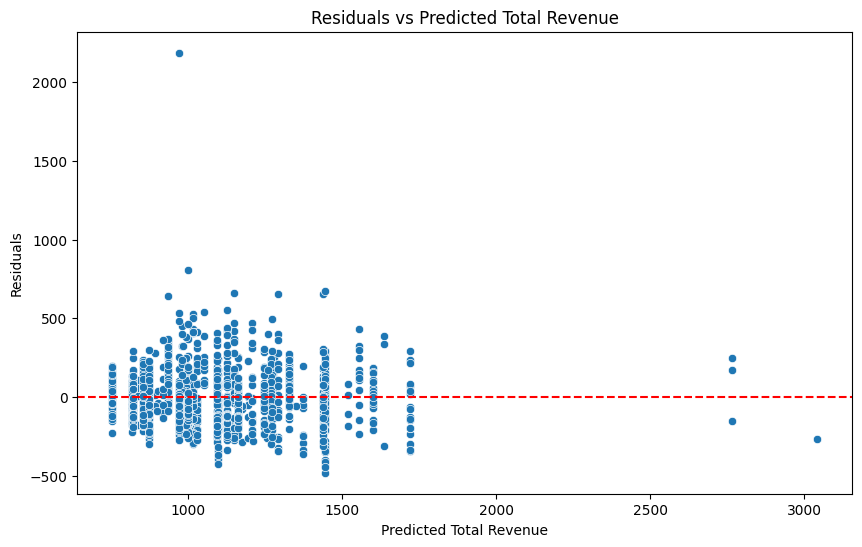

In [299]:
# evaluating my model 

# use residuals to understand fit
# cannot follow the videos because my test set is empty

# using copilots suggestions to evaluate model using residuals
import matplotlib.pyplot as plt
import seaborn as sns
# calculate residuals
residuals = Y - predict
# plot residuals
plt.figure(figsize=(10,6))
sns.scatterplot(x=predict, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Total Revenue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Total Revenue')
plt.show()

# the graph that comes out is different from the video



In [300]:
# VIDEO: LLMs for model iterations

# following the videos, i do another attempt to improve the multi linear model's R quared by asking chat gpt

# creating fourier seasonality variable 

import numpy as np
import pandas as pd

# Ensure datetime index and sorted order
train_df.index = pd.to_datetime(train_df.index)
train_df = train_df.sort_index()

# Elapsed time in days since first observation
t_days = (train_df.index - train_df.index[0]).total_seconds() / (24 * 3600)

# Add YEARLY Fourier terms (K=3 is a good starting point)
K = 3
period_in_days = 365.25

for k in range(1, K + 1):
    train_df[f"year_sin{k}"] = np.sin(2 * np.pi * k * t_days / period_in_days)
    train_df[f"year_cos{k}"] = np.cos(2 * np.pi * k * t_days / period_in_days)
    
fourier_cols = [f"year_sin{k}" for k in range(1, K + 1)] + \
               [f"year_cos{k}" for k in range(1, K + 1)]


predictors = [
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month',
    'KielerWeek',
    'IsNewYearsEve',
    "IsHalloween",
]

predictors_extended = predictors + fourier_cols

train_df.head()


,Total Revenue,CloudCover,Temperature,WindSpeed,WeatherCode,KielerWeek,Holiday,Easter,Year,Weekday,...,Month,Lag7_Total_Revenue,IsNewYearsEve,IsHalloween,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3
Date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,1269.249107,6.0,17.8375,15.0,20.0,False,True,0.0,2013.0,Monday,...,7,NaN,False,False,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-07-02,1430.008397,3.0,17.3125,10.0,NaN,False,True,0.0,2013.0,Tuesday,...,7,NaN,False,False,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
2013-07-03,1124.274894,7.0,21.0750,6.0,61.0,False,True,0.0,2013.0,Wednesday,...,7,NaN,False,False,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678
2013-07-04,1184.309567,7.0,18.8500,7.0,20.0,False,True,0.0,2013.0,Thursday,...,7,NaN,False,False,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039
2013-07-05,1288.023060,5.0,19.9750,12.0,NaN,False,True,0.0,2013.0,Friday,...,7,NaN,False,False,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769


In [301]:
print(X.columns)


Index(['const', 'Season_Spring', 'Season_Summer', 'Season_Autumn',
       'NextDayHoliday_True', 'Holiday_True', 'IsWeekend_True', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'KielerWeek_True',
       'IsNewYearsEve_True', 'IsHalloween_True'],
      dtype='object')


In [302]:
# I delete season from my predictors because it is co-linear with the fourier variables (i need to change it in predictors = [bla, bla] because i added my new varibales to predictors_extended, which includes my old predictors)
# i tried deleting month too, but it decreased the r^2 
predictors = [
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month',
    'KielerWeek',
    'IsNewYearsEve',
    "IsHalloween",
]

# running the OLS with new Fourier variables, to see if the r^2 increased (i delete season because with or without season the r^2 doesn't change so they are very likely collinear)

Y = train_df['Total Revenue']

# Use predictors_extended which includes both regular predictors and Fourier terms
X = sm.add_constant(
    pd.get_dummies(
        train_df[predictors_extended],
        columns=[
            'NextDayHoliday',
            'Holiday',
            'IsWeekend',
            'Month',
            'KielerWeek',
            'IsNewYearsEve',
            'IsHalloween'
        ],
        drop_first=True,
        dtype=float
    )
)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())




                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:46   Log-Likelihood:                -9531.8
No. Observations:                1461   AIC:                         1.911e+04
Df Residuals:                    1437   BIC:                         1.924e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 871.0018    

In [303]:
# creating csv file with train_df so i can see all my variables 

train_df.to_csv("train_df.csv", index=True)


In [304]:
# trying to improve my R^2 by taking into consideration that while evenue follows a similar yearly and weekly pattern, each year revenue is decreasing (the best year was 2024)
# so I add a time trend

train_df["t"] = np.arange(len(train_df))

In [305]:
#  i add a one day lag,and weekly and monthly mean

train_df["lag_1"] = train_df["Total Revenue"].shift(1)

train_df["roll7_mean"]  = train_df["Total Revenue"].shift(1).rolling(7).mean()
train_df["roll28_mean"] = train_df["Total Revenue"].shift(1).rolling(28).mean()


# i forecast tomorrow

train_df["y_next"] = train_df["Total Revenue"].shift(-1)


In [306]:
# i create new predictors (still including the other ones), because using the other one is confusing. I call it predictors_final

predictors_final = [
    'Holiday',
    'NextDayHoliday',
    'IsWeekend',
    'Month',
    'KielerWeek',
    'IsNewYearsEve',
    "IsHalloween",
    "t",
    "lag_1",
    "Lag7_Total_Revenue",
    "roll7_mean",
    "roll28_mean",
    "year_sin1", "year_cos1",
    "year_sin2", "year_cos2"
]


In [307]:
# now i run the OLS with the new predictors_final
Y = train_df['Total Revenue']
X = sm.add_constant(
    pd.get_dummies(
        train_df[predictors_final],
        columns=[
            'NextDayHoliday',
            'Holiday',
            'IsWeekend',
            'Month',
            'KielerWeek',
            'IsNewYearsEve',
            'IsHalloween'
        ],
        drop_first=True,
        dtype=float
    )
)

# making sure there are no NaN values in X and Y
valid_idx = X.dropna().index.intersection(Y.dropna().index)
X = X.loc[valid_idx]
Y = Y.loc[valid_idx]

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     179.2
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:43:47   Log-Likelihood:                -9113.8
No. Observations:                1433   AIC:                         1.828e+04
Df Residuals:                    1406   BIC:                         1.842e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 283.0099    

In [308]:
# now that i have a high (ish) r squared i want to test the model on the validation set

# i know that the validation set needs to have the fourier variables and the lag and rolling mean variables
import numpy as np
import pandas as pd
# Ensure datetime index and sorted order
validation_df.index = pd.to_datetime(validation_df.index)
validation_df = validation_df.sort_index()
# Elapsed time in days since first observation in training set
t_days_val = (validation_df.index - train_df.index[0]).total_seconds() / (24 * 3600)
# Add YEARLY Fourier terms (K=3 is a good starting point)
K = 3   
period_in_days = 365.25
for k in range(1, K + 1):
    validation_df[f"year_sin{k}"] = np.sin(2 * np.pi * k * t_days_val / period_in_days)
    validation_df[f"year_cos{k}"] = np.cos(2 * np.pi * k * t_days_val / period_in_days)
# Add time trend
validation_df["t"] = np.arange(len(train_df), len(train_df) + len(validation_df))
# Add lag and rolling mean features
validation_df["lag_1"] = validation_df["Total Revenue"].shift(1)
validation_df["roll7_mean"]  = validation_df["Total Revenue"].shift(1).rolling(7).mean()
validation_df["roll28_mean"] = validation_df["Total Revenue"].shift(1).rolling(28).mean()
validation_df["y_next"] = validation_df["Total Revenue"].shift(-1)
validation_df.head()    

# i check if the columns are the same as in train_df
set(train_df.columns) == set(validation_df.columns)

# they areeee!


True

In [309]:
# now i can run the model on the validation set
Y_val = validation_df['Total Revenue']
X_val = sm.add_constant(
    pd.get_dummies(
        validation_df[predictors_final],
        columns=[
            'NextDayHoliday',
            'Holiday',
            'IsWeekend',
            'Month',
            'KielerWeek',
            'IsNewYearsEve',
            'IsHalloween'
        ],
        drop_first=True,
        dtype=float
    )
)
# making sure there are no NaN values in X_val and Y_val
valid_idx_val = X_val.dropna().index.intersection(Y_val.dropna().index)
X_val = X_val.loc[valid_idx_val]
Y_val = Y_val.loc[valid_idx_val]

model_val = sm.OLS(Y_val, X_val)
results_val = model_val.fit()
print(results_val.summary())

                            OLS Regression Results                            
Dep. Variable:          Total Revenue   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     59.78
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          2.91e-101
Time:                        11:43:47   Log-Likelihood:                -1988.5
No. Observations:                 327   AIC:                             4029.
Df Residuals:                     301   BIC:                             4128.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2939.2393   1

In [342]:
# preparing data for kaggle upload

# i delete the columns that i am not using in my regression model from the train_df 
train_df_model_final = train_df[predictors_final + ['Total Revenue']]
train_df_model_final.head()

,Holiday,NextDayHoliday,IsWeekend,Month,KielerWeek,IsNewYearsEve,IsHalloween,t,lag_1,Lag7_Total_Revenue,roll7_mean,roll28_mean,year_sin1,year_cos1,year_sin2,year_cos2,Total Revenue
Date,,,,,,,,,,,,,,,,,
2013-07-01,True,True,False,7,False,False,False,0,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,1269.249107
2013-07-02,True,True,False,7,False,False,False,1,1269.249107,NaN,NaN,NaN,0.017202,0.999852,0.034398,0.999408,1430.008397
2013-07-03,True,True,False,7,False,False,False,2,1430.008397,NaN,NaN,NaN,0.034398,0.999408,0.068755,0.997634,1124.274894
2013-07-04,True,True,False,7,False,False,False,3,1124.274894,NaN,NaN,NaN,0.051584,0.998669,0.103031,0.994678,1184.309567
2013-07-05,True,True,False,7,False,False,False,4,1184.309567,NaN,NaN,NaN,0.068755,0.997634,0.137185,0.990545,1288.023060


In [343]:
# i do the same for the validation_df
validation_df_model_final = validation_df[predictors_final + ['Total Revenue']]
validation_df_model_final.head()

,Holiday,NextDayHoliday,IsWeekend,Month,KielerWeek,IsNewYearsEve,IsHalloween,t,lag_1,Lag7_Total_Revenue,roll7_mean,roll28_mean,year_sin1,year_cos1,year_sin2,year_cos2,Total Revenue
Date,,,,,,,,,,,,,,,,,
2017-08-01,True,True,False,8,False,False,False,1461,NaN,1271.049886,NaN,NaN,0.508356,0.861147,0.875539,0.483147,1432.551319
2017-08-02,True,True,False,8,False,False,False,1462,1432.551319,1337.912698,NaN,NaN,0.523094,0.852275,0.891640,0.452745,1521.921055
2017-08-03,True,True,False,8,False,False,False,1463,1521.921055,1472.595496,NaN,NaN,0.537677,0.843151,0.906686,0.421806,1272.634239
2017-08-04,True,True,False,8,False,False,False,1464,1272.634239,1374.092625,NaN,NaN,0.552101,0.833777,0.920659,0.390368,1415.948298
2017-08-05,True,True,True,8,False,False,False,1465,1415.948298,1454.881215,NaN,NaN,0.566362,0.824157,0.933542,0.358468,1554.114319


In [ ]:
# i upload test.csv
test_df = pd.read_csv("/workspaces/TeamCPH/data/test.csv", parse_dates=["Datum"])  
test_df.rename(columns={"Datum": "Date"}, inplace=True)
test_df.set_index("Date", inplace=True)
test_df.head()

# i add total revenue column to test_df
test_df['Total Revenue'] = pd.NA
test_df.head()

# i delete warengruppe column from test dataframe
del test_df["Warengruppe"]
test_df.head()

# i delete date index from test_df
test_df.reset_index(inplace=True)
test_df.head()

# i delete date column from test_df
del test_df["Date"]
test_df.head()


,id,Total Revenue
0,1808011,<NA>
1,1808021,<NA>
2,1808031,<NA>
3,1808041,<NA>
4,1808051,<NA>


In [364]:
# i create a csv file out of my training set
train_df_model_final.to_csv("train_df_model_final.csv", index=True)


In [368]:
# following chat gpt's instructions because i don't know what else to do

import pandas as pd

# i load train_df_model_final and test_df
train_df = pd.read_csv("train_df_model_final.csv", parse_dates=["Date"])
test_df = pd.read_csv("/workspaces/TeamCPH/data/test.csv", parse_dates=["Datum"])
test_df.rename(columns={"Datum": "Date"}, inplace=True)
test_df.set_index("Date", inplace=True)


In [369]:
test_df.head()  

,id,Warengruppe
Date,,
2018-08-01,1808011,1
2018-08-02,1808021,1
2018-08-03,1808031,1
2018-08-04,1808041,1
2018-08-05,1808051,1


In [370]:
# deleting warengruppe column from test dataframe
del test_df["Warengruppe"]

# adding total revenue column to test_df
test_df['Total Revenue'] = pd.NA
test_df.head()

,id,Total Revenue
Date,,
2018-08-01,1808011,<NA>
2018-08-02,1808021,<NA>
2018-08-03,1808031,<NA>
2018-08-04,1808041,<NA>
2018-08-05,1808051,<NA>


In [376]:
import importlib
print(importlib.util.find_spec("sklearn"))
print(importlib.util.find_spec("statsmodels"))

!pip install scikit-learn


None
ModuleSpec(name='statsmodels', loader=<_frozen_importlib_external.SourceFileLoader object at 0x704bfa5a0a40>, origin='/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/__init__.py', submodule_search_locations=['/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels'])
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [ ]:
print(train_df.columns.tolist())

['Date', 'Holiday', 'NextDayHoliday', 'IsWeekend', 'Month', 'KielerWeek', 'IsNewYearsEve', 'IsHalloween', 't', 'lag_1', 'Lag7_Total_Revenue', 'roll7_mean', 'roll28_mean', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'Total Revenue']
